In [4]:

import colorsys
import pathlib
from typing import Any, Dict, List, Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
import umap  # type: ignore
from mmengine.fileio import load
from hod.utils.tree import HierarchyNode, HierarchyTree

# import seaborn as sns
# sns.set_theme(style='white')

ann_file = "../data/aircraft/hierarchical/aircraft_test.json"

# -----------------------------------------------------------------------------
# Colour utilities
# -----------------------------------------------------------------------------

def build_hue_map(root: HierarchyNode, shrink: float = 0.8) -> Dict[str, float]:
    """
    Assign hues so siblings at shallow levels get strong separation.
    `shrink < 1` compresses the span passed down to each generation.
    """
    hue_map: Dict[str, float] = {}

    def _recurse(node: HierarchyNode, start: float, end: float, depth: int) -> None:
        hue_map[node.name] = (start + end) / 2
        if not node.children:
            return

        # after the first split, shrink the usable span
        usable_span = (end - start) * (1.0 if depth == 0 else shrink)
        left_gap = ((end - start) - usable_span) / 2
        span_start = start + left_gap
        width = usable_span / len(node.children)

        for idx, child in enumerate(sorted(node.children)):
            cs = span_start + idx * width
            ce = cs + width
            _recurse(child, cs, ce, depth + 1)

    _recurse(root, 0.0, 1.0, 0)
    return hue_map



# -----------------------------------------------------------------------------
# Plotting logic
# -----------------------------------------------------------------------------


def plot_embeddings_umap(model_path: pathlib.Path | str, ann_file: pathlib.Path | str, *, random_state: int = 42) -> None:
    """Project the classifier embeddings with **UMAP** and colour by taxonomy."""

    # ----------------------- 1. load embeddings ------------------------
    state = torch.load(model_path, map_location="cpu", weights_only=False)
    if "state_dict" in state:
        state = state["state_dict"]
    embeddings_tensor = state["bbox_head.cls_branches.0.embeddings"].detach().cpu()
    embeddings = embeddings_tensor.numpy()

    # ------------------------- 2. UMAP fit -----------------------------
    reducer = umap.UMAP(random_state=random_state)
    umap_2d: np.ndarray = reducer.fit_transform(embeddings)

    # --------------------- 3. load taxonomy JSON ----------------------
    ann = load(ann_file)

    if len(embeddings) != len(ann["categories"]):
        raise ValueError(
            f"Number of embeddings ({len(embeddings)}) does not match number of "
            f"categories ({len(ann['categories'])})."
        )

    labels: List[str] = [cat["name"] for cat in ann["categories"]]

    hierarchy = HierarchyTree(ann["taxonomy"])
    hue_map = build_hue_map(hierarchy.root)

    # Compute depth stats once for lightness scaling
    depths: List[int] = []
    for name in labels:
        if name in hierarchy.class_to_node:
            depths.append(hierarchy.class_to_node[name].get_depth())
    min_depth = min(depths) if depths else 0
    max_depth = max(depths) if depths else 0

    # ----------------------- 4. colour array --------------------------
    colours: List[tuple[float, float, float]] = []
    for cat_name in labels:
        node = hierarchy.class_to_node.get(cat_name)
        if node is None:
            # Taxonomy / annotation mismatch – grey colour
            colours.append(colorsys.hls_to_rgb(0.0, 0.5, 0.0))
            continue

        base_h = hue_map[node.name]

        if max_depth > min_depth:
            norm = (node.get_depth() - min_depth) / (max_depth - min_depth)
            lightness = 0.3 + 0.5 * norm  # [0.3, 0.8]
        else:
            lightness = 0.55  # flat hierarchy

        rgb = colorsys.hls_to_rgb(base_h, lightness, 0.9)
        colours.append(rgb)

    # ----------------------- 5. plot scatter --------------------------
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(umap_2d[:, 0], umap_2d[:, 1], s=35, c=colours, alpha=0., linewidths=0.3, edgecolors="k")

    # for (x, y), lbl in zip(umap_2d, labels):
    #     ax.text(x, y, lbl, fontsize=6, alpha=0.5, ha="center", va="bottom")
    for (x, y), lbl, col in zip(umap_2d, labels, colours):
        ax.text(
            x,
            y,
            lbl,
            color=col,        # use the hue/lightness we already computed
            fontsize=6,
            ha="center",
            va="center",
            alpha=0.9,        # tweak if you want fainter text
            weight="bold",    # optional: helps legibility
        )

    ax.set_title("UMAP projection of classifier embeddings", fontsize=14)
    ax.set_xlabel("UMAP‑1")
    ax.set_ylabel("UMAP‑2")
    ax.set_aspect("equal", adjustable="box")
    fig.tight_layout()
    plt.show()



/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


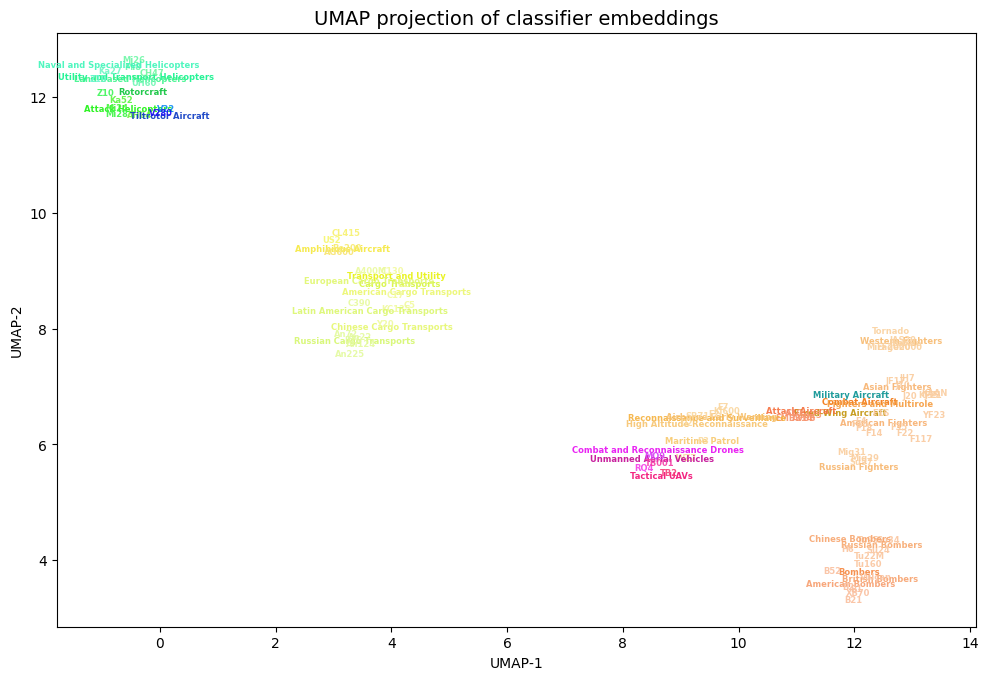

In [7]:
path = "../work_dirs/dino-4scale_r50_improved_8xb2_hier-aircraft-2x-cost/epoch_36.pth"
plot_embeddings_umap(path, ann_file)

/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


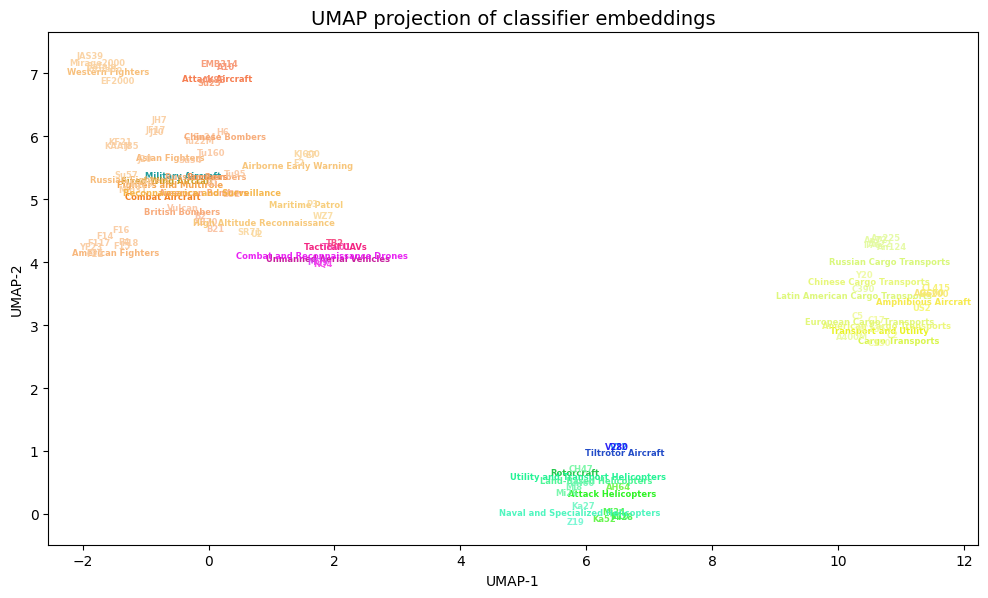

In [8]:
path = "../work_dirs/dino-4scale_r50_improved_8xb2_hier-aircraft-3x-cost-entail-full/epoch_36.pth"
plot_embeddings_umap(path, ann_file)


/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


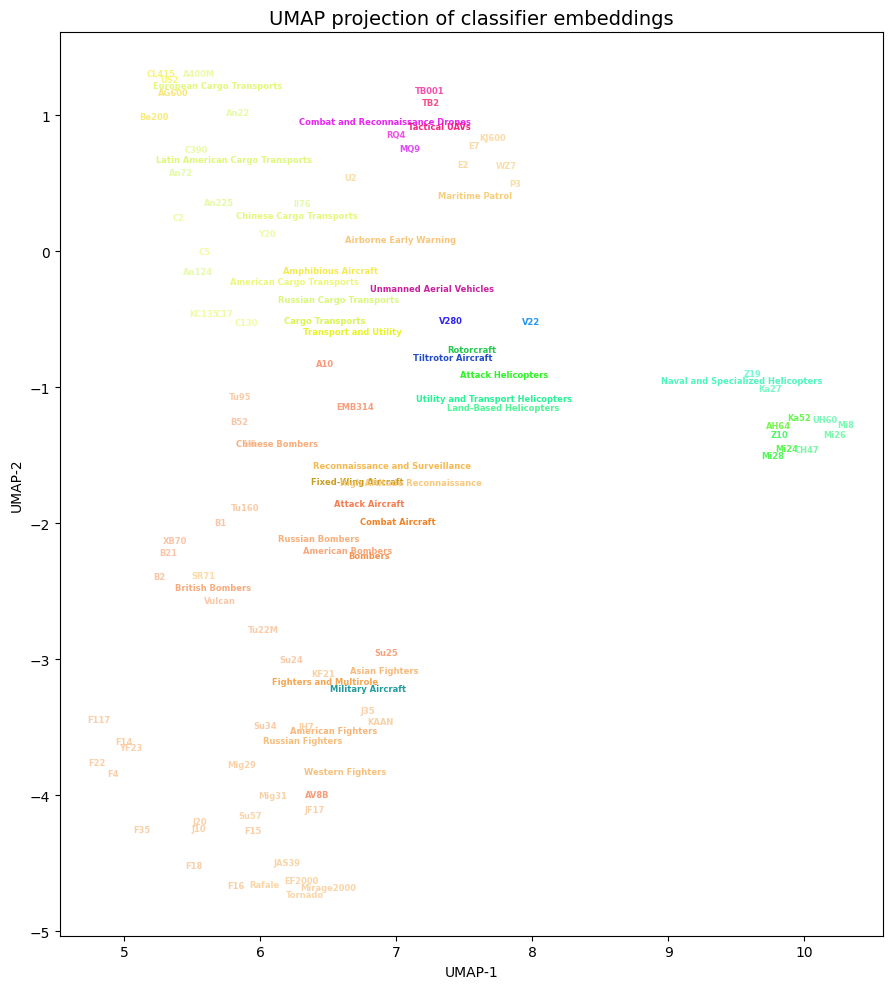

In [17]:
path = "../work_dirs/dino-4scale_r50_improved_8xb2_hier-aircraft/epoch_6.pth"
plot_embeddings_umap(path, ann_file)